## FreqPulse-VAE: A Frequency-Conditioned Variational Autoencoder for Pulsatile Signal Generation

In [31]:
import os
import numpy as np
import pandas as pd
import yaml


import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, GRU, Dense, Masking, Reshape, Flatten, RepeatVector, TimeDistributed, Bidirectional, Activation, GaussianNoise, Lambda, LSTM
from tensorflow.keras import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from Models.MainModel import *
from Utilities.Utilities import *
from Utilities.EvaluationModules import *
from Models.Losses import *

import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="4"

def read_yaml(file_path):
    with open(file_path, 'r') as file:
        return yaml.safe_load(file)

#### Env setting

In [48]:
ConfigName = 'DKZFC_ART_50_800'


if 'ART' in ConfigName:
    LoadConfig = 'Config' + 'ART'
elif 'PLETH' in ConfigName:
    LoadConfig = 'Config' + 'PLETH'
elif 'II' in ConfigName:
    LoadConfig = 'Config' + 'II'
else:
    assert False, "Please verify if the data type is properly included in the name of the configuration. The configuration name should be structured as 'Config' + 'data type', such as ConfigART."

yaml_path = './Config/'+LoadConfig+'.yml'

SavePath = './Results/'
ConfigSet = read_yaml(yaml_path)

### Model related parameters
SigType = ConfigSet[ConfigName]['SigType']
LatDim = ConfigSet[ConfigName]['LatDim']
CompSize = ConfigSet[ConfigName]['CompSize']

MaskingRate = ConfigSet[ConfigName]['MaskingRate']
NoiseStd = ConfigSet[ConfigName]['NoiseStd']
MaskStd = ConfigSet[ConfigName]['MaskStd']
ReparaStd = ConfigSet[ConfigName]['ReparaStd']
FcLimit = ConfigSet[ConfigName]['FcLimit']
DecayH = ConfigSet[ConfigName]['DecayH']
DecayL = ConfigSet[ConfigName]['DecayL']
BatSize = ConfigSet[ConfigName]['BatSize']
NEpochs = ConfigSet[ConfigName]['NEpochs']

WRec = ConfigSet[ConfigName]['WRec']
WFeat = ConfigSet[ConfigName]['WFeat']
WZ = ConfigSet[ConfigName]['WZ']
WFC = ConfigSet[ConfigName]['WFC']
WTC = ConfigSet[ConfigName]['WTC']
WMI = ConfigSet[ConfigName]['WMI']

### Other parameters
MnWRec = ConfigSet[ConfigName]['MnWRec']
MnWFeat = ConfigSet[ConfigName]['MnWFeat']
MnWZ = ConfigSet[ConfigName]['MnWZ']
MnWFC = ConfigSet[ConfigName]['MnWFC']
MnWTC = ConfigSet[ConfigName]['MnWTC']
MnWMI = ConfigSet[ConfigName]['MnWMI']

MxWRec = ConfigSet[ConfigName]['MxWRec']
MxWFeat = ConfigSet[ConfigName]['MxWFeat']
MxWZ = ConfigSet[ConfigName]['MxWZ']
MxWFC = ConfigSet[ConfigName]['MxWFC']
MxWTC = ConfigSet[ConfigName]['MxWTC']
MxWMI = ConfigSet[ConfigName]['MxWMI']

ModelName = ConfigName+'.hdf5'
### Model checkpoint
ModelSaveName = SavePath+ModelName


### Data

In [15]:
TrData = np.load('./Data/ProcessedData/Tr'+str(SigType)+'.npy')
ValData = np.load('./Data/ProcessedData/Val'+str(SigType)+'.npy')

SigDim = ValData.shape[1]

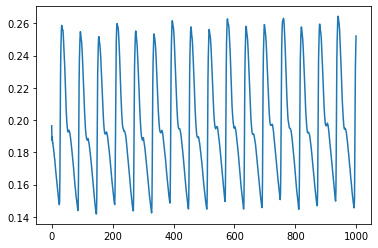

In [4]:
plt.plot(ValData[9])

In [23]:
np.log(1/DataSize)

-12.611537753638338

### Post model

In [49]:
# Defining Modesl
EncModel = Encoder(SigDim=SigDim, LatDim= LatDim, Type = '', MaskingRate = MaskingRate, NoiseStd = NoiseStd, MaskStd = MaskStd, ReparaStd = ReparaStd, Reparam=False, FcLimit=FcLimit)
FeatExtModel = FeatExtractor(SigDim=SigDim, CompSize = CompSize, DecayH=DecayH, DecayL=DecayL)
FeatGenModel = FeatGenerator(SigDim=SigDim,FeatDim=FeatExtModel.output[1].shape[-1], LatDim= LatDim)
ReconModel = Reconstructor(SigDim=SigDim, FeatDim=FeatExtModel.output[1].shape[-1])

Models = [EncModel,FeatExtModel,FeatGenModel,ReconModel] 

# Adding losses
SigRepModel = TCLosses(Models, BatSize, ConfigSet[ConfigName], ModelType=ConfigName)


### Load weights
SigRepModel.load_weights(ModelSaveName)

### Regularizer resetting
for i in SigRepModel.weights:
    if i.name.split('/')[0] in ['Beta_Z','Beta_Fc','Beta_TC', 'Beta_MI' ,'Beta_Orig', 'Beta_Feat']:
        i.assign(1.)
        
## Model Compile
SigRepModel.compile(optimizer='adam') 
SigRepModel.summary()

OrigRecLoss added
FeatRecLoss added
DKZ loss selected
kl_Loss_Z added
kl_Loss_FC added
Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Inp_Enc (InputLayer)            [(None, 1000)]       0                                            
__________________________________________________________________________________________________
tf.signal.frame_42 (TFOpLambda) (None, 20, 50)       0           Inp_Enc[0][0]                    
__________________________________________________________________________________________________
bidirectional_108 (Bidirectiona (None, 20, 50)       11550       tf.signal.frame_42[0][0]         
__________________________________________________________________________________________________
bidirectional_109 (Bidirectiona (None, 20, 50)       11550       bidirectional_108[0][0]          
_____

### Reconstruction; MSE

In [38]:
RecPred = SigRepModel.predict(ValData,  batch_size=3500, verbose=1)[-1]

23/23 [==============================] - 14s 203ms/step


In [5]:
SigRepModel.evaluate(ValData,  batch_size=3000, verbose=1)

20/20 [==============================] - 57s 2s/step - loss: 0.0713 - OrigRecLoss: 5.6783e-04 - FeatRecLoss: 1.5066e-04 - kl_Loss_Z: 0.0721 - kl_Loss_FC: 5.0600e-05


[0.07283733040094376,
 0.0005678327288478613,
 0.000150659863720648,
 0.0720682293176651,
 5.060029070591554e-05]

In [ ]:
EvalMSE = tf.keras.losses.MeanSquaredError()
EvalMSE(ValData, RecPred)

### From extractor to reconstruction validation 
#### It ultimately evaluates the performance of the reconstructor

(100, 1000)


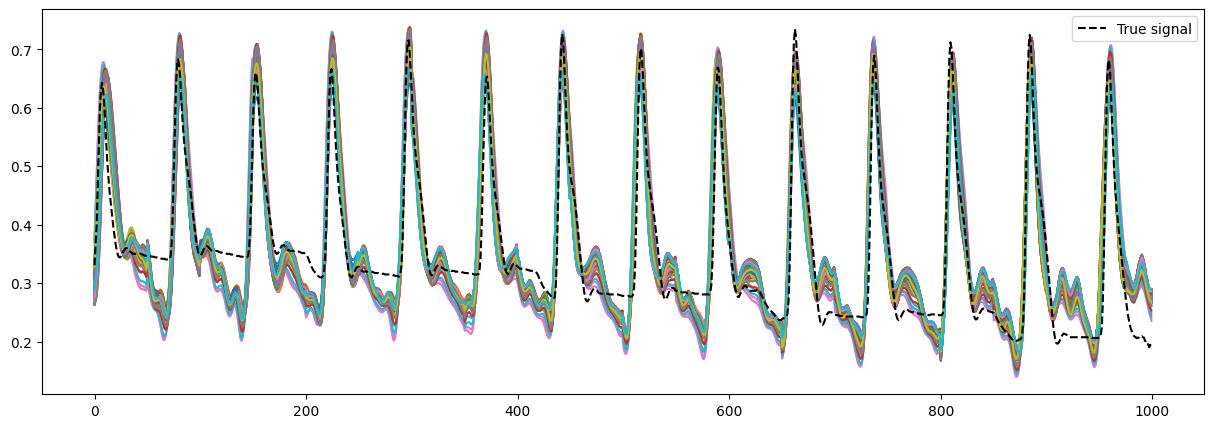

In [50]:
idx = 0

N_Gen = 100
'''
FC_Comm = np.tile(np.linspace(0.,0.05, N_Gen )[:, None], (1,2))
FC_Each = np.tile(np.linspace(0.,0.05, N_Gen )[:, None], (1,4))

'''
FC_Comm = np.tile(np.random.uniform(0, 0.05, N_Gen)[:, None], (1,2))
FC_Comm = np.sort(FC_Comm)
FC_Each = np.tile(np.random.uniform(0, 0.05, N_Gen)[:, None], (1,4))
FC_Each = np.sort(FC_Each) 


RecPred, HH,HL,LH, LL = VisReconExtract (ValData, idx, FeatExtModel, ReconModel, FC_Comm, FC_Each, N_Gen=N_Gen)

#### From extractor to reconstruction LL

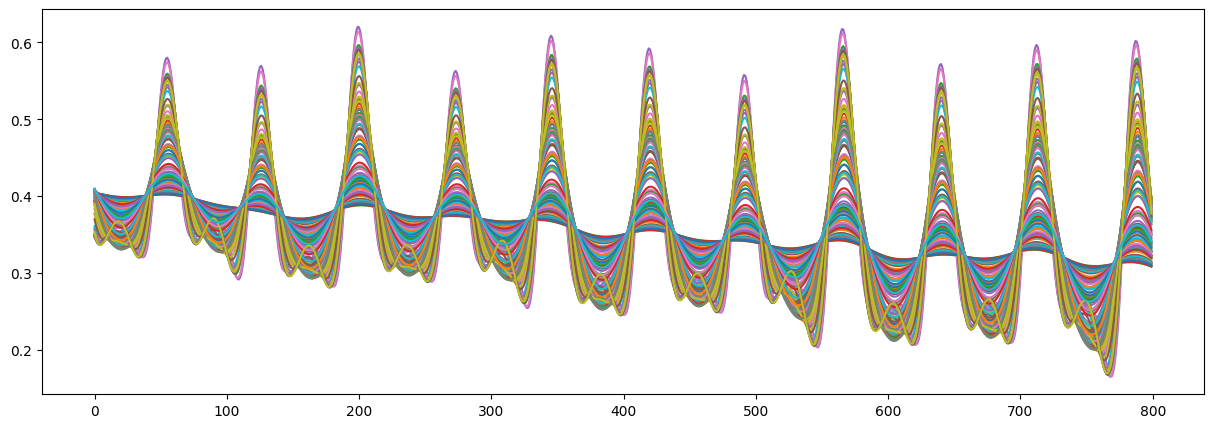

In [45]:
plt.figure(figsize=(15, 5))
for i in range(N_Gen):
    plt.plot(LL.numpy()[i])

#### From extractor to reconstruction HH

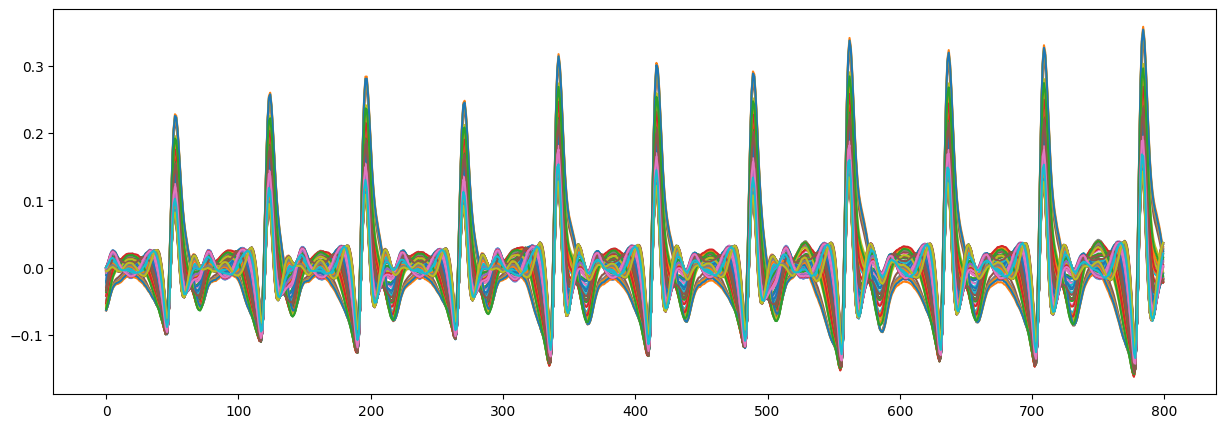

In [15]:
plt.figure(figsize=(15, 5))
for i in range(N_Gen):
    plt.plot(HH.numpy()[i])

In [22]:
DataSize = TrData.shape[0]


3.3333333333333333e-06

### The ratio of weighted power concentration to uncertainty (RWPCU)

In [51]:
RWPCU_Res = RWPCU(FeatGenModel,  ReconModel, LatDim=LatDim, N_Gen=300, N_Interval=20,
                  MinZval = -10., MaxZval = 10., N_FreqSel =3,  
                 MinFreq=1, MaxFreq=51)

['Lat_ID', 'zVal', 'Numerator', 'Denominator', 'VCSAE']
[0, -10.0, 0.3607, 0.34524, 1.04479]
[0, -8.95, 0.69002, 0.32371, 2.13156]
[0, -7.89, 0.19924, 0.32186, 0.61901]
[0, -6.84, 0.24863, 0.24131, 1.03031]
[0, -5.79, 0.29371, 0.19734, 1.48835]
[0, -4.74, 0.27274, 0.12174, 2.24025]
[0, -3.68, 0.24995, 0.13925, 1.79503]
[0, -2.63, 0.3746, 0.21194, 1.76748]
[0, -1.58, 0.67496, 0.29704, 2.27232]
[0, -0.53, 0.54537, 0.3212, 1.69793]
[0, 0.53, 0.46321, 0.29517, 1.56929]
[0, 1.58, 0.42164, 0.32735, 1.28806]
[0, 2.63, 0.54523, 0.4299, 1.26827]
[0, 3.68, 0.62816, 0.50757, 1.23758]
[0, 4.74, 0.62756, 0.45791, 1.3705]
[0, 5.79, 0.49417, 0.32041, 1.54231]
[0, 6.84, 0.17529, 0.17577, 0.99726]
[0, 7.89, 0.20197, 0.14504, 1.39253]
[0, 8.95, 0.26562, 0.09123, 2.91155]
[0, 10.0, 0.12426, 0.14941, 0.83165]
[1, -10.0, 0.19954, 0.19366, 1.03034]
[1, -8.95, 0.35552, 0.25759, 1.38015]
[1, -7.89, 0.42902, 0.24695, 1.73726]
[1, -6.84, 0.33089, 0.23248, 1.42327]
[1, -5.79, 0.17663, 0.18648, 0.94721]
[1, -4.74

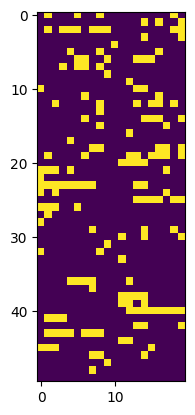

In [53]:
plt.imshow(np.array(RWPCU_Res)[:, -1].reshape(-1, 20) > 2.)

### Qualitative evaluation of the amplitude relationship between the input frequency for signal generation (y-axis) and the frequency of the generated signal (x-axis).

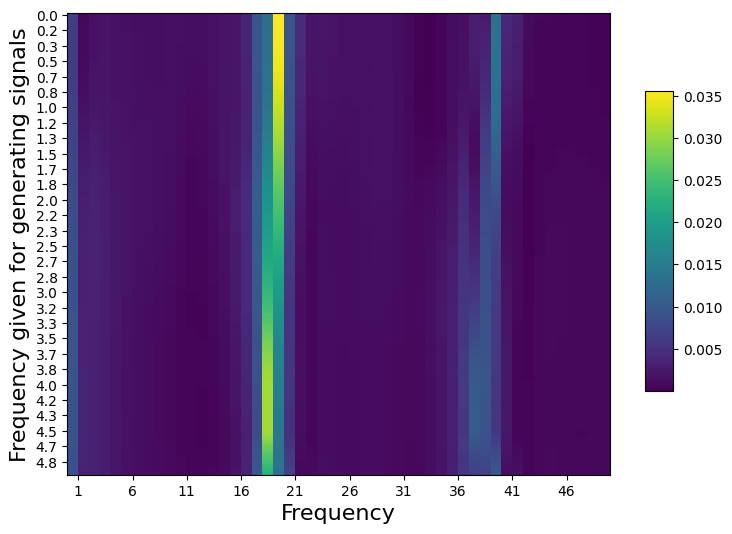

In [66]:
ZFix = {17:-6.84}
#ZFix = {2:1.32, 9:3.32}
#zVal[:,0] = -3
#Val[:,1] = 2.33
#zVal[:,2] = 0.4
#zVal[:,3] = -1.67
#zVal[:,4] = 0.33
#zVal[:,5] = 3
#zVal[:,6] = -1.67
#zVal[:,7] = 3
#zVal[:,8] = 3
#zVal[:,9] = -1

HeatMapFrequency(FeatGenModel,  ReconModel, LatDim, ZFix, N_Gen=300)

### Visualizing the reconstruction conditioned on a specific z-value when frequencies are given at regular intervals
#### Objective: This qualitatively evaluates the impact of changes in input frequencies on signal generation when a specific z-value is given.

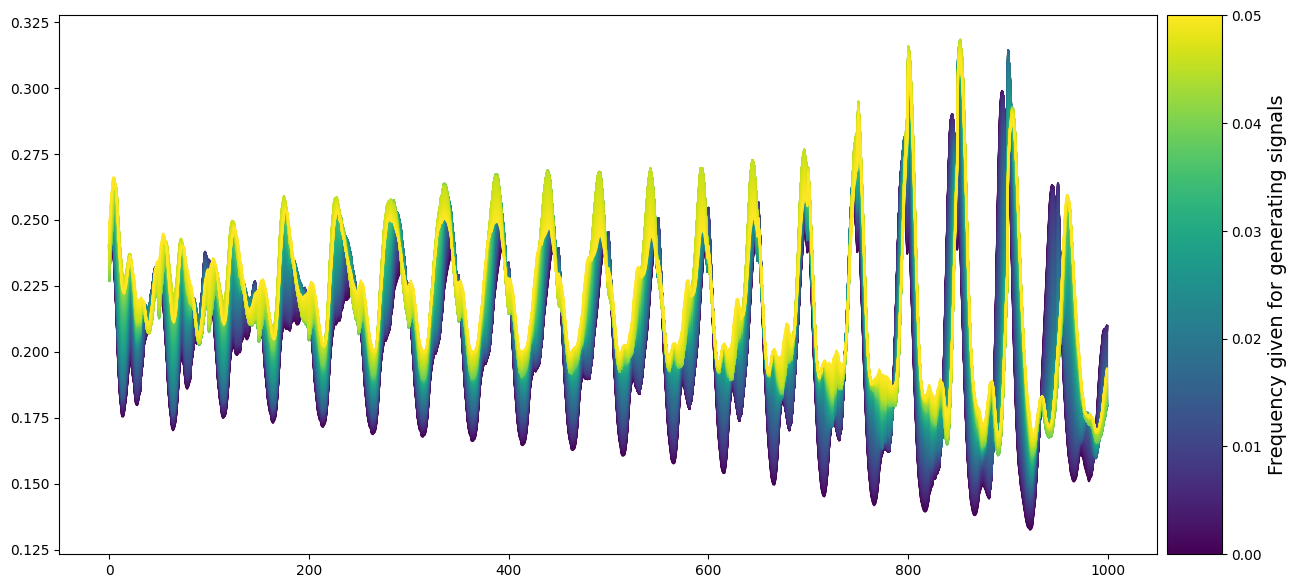

In [67]:
RecPred, HH,HL,LH, LL = VisReconGivenZ (FeatGenModel,  ReconModel, LatDim, ZFix, Mode='Origin', N_Gen=300, MinFreqR=0, MaxFreqR=0.05)

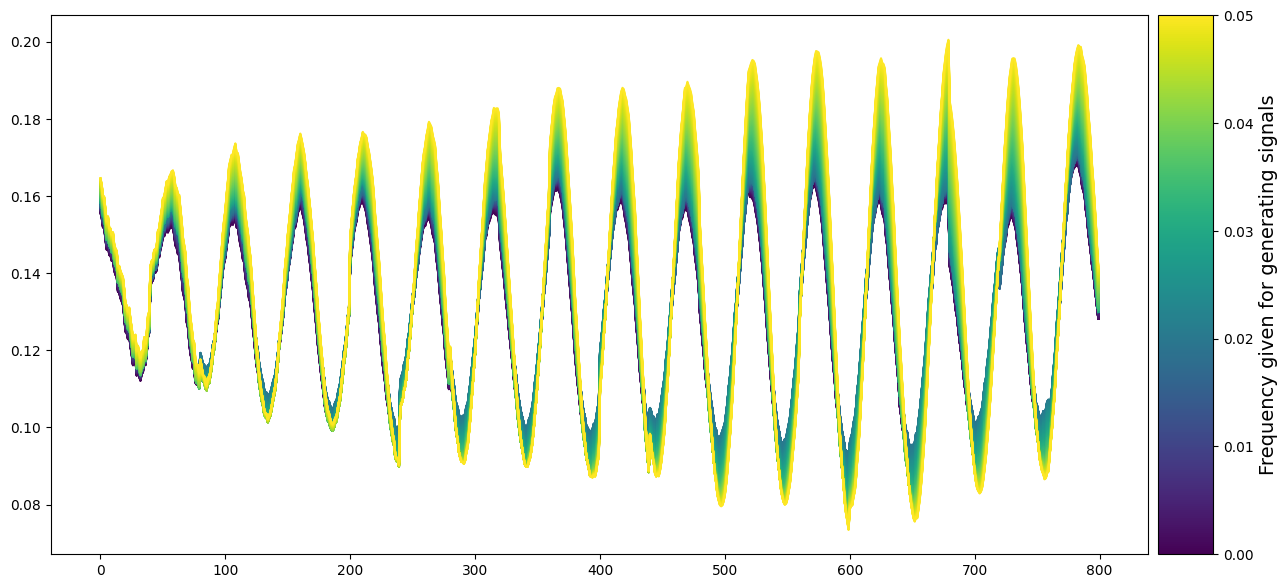

In [47]:
RecPred, HH,HL,LH, LL = VisReconGivenZ (FeatGenModel,  ReconModel, LatDim, ZFix, Mode='LL', N_Gen=300, MinFreqR=0, MaxFreqR=0.05)

### Visualizing the reconstruction conditioned on a specific frequency value when z-values are given at regular intervals
#### Objective: This qualitatively evaluates the impact of changes in input z-values on signal generation when a specific frequency is given.

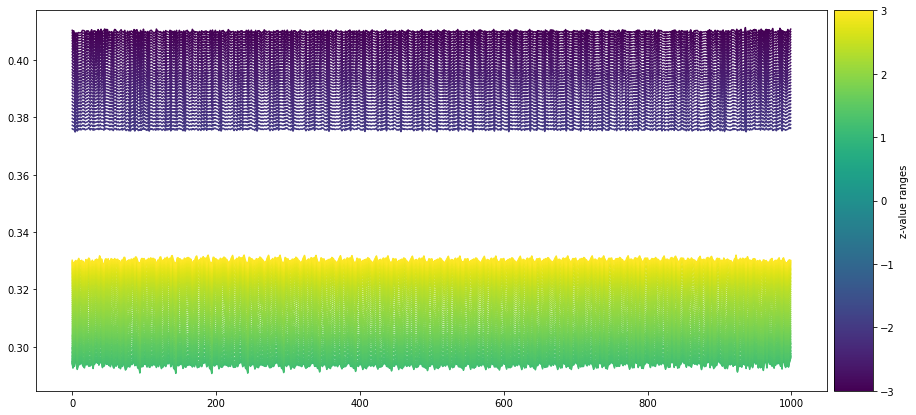

In [33]:
FcCommFix = {0:0.05, 1:0.05}
FcEachFix = {0:0.05, 1:0.05, 2:0.05, 3:0.05}
RecPred, HH,HL,LH, LL = VisReconGivenFreq (FeatGenModel,  ReconModel, LatDim, FcCommFix, FcEachFix,  Mode='Origin', N_Gen=200, MinZval = -3., MaxZval = 3., CutLower=-2., CutUpper = 1.)

### From generator to reconstruction validation

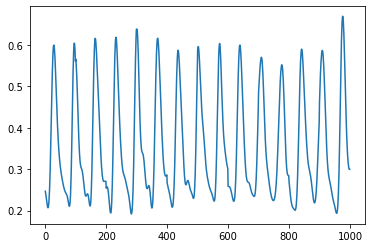

In [25]:
idx = 175
plt.plot(RecPred[idx])

### Visualizing amplitude by frequency given a specific ID

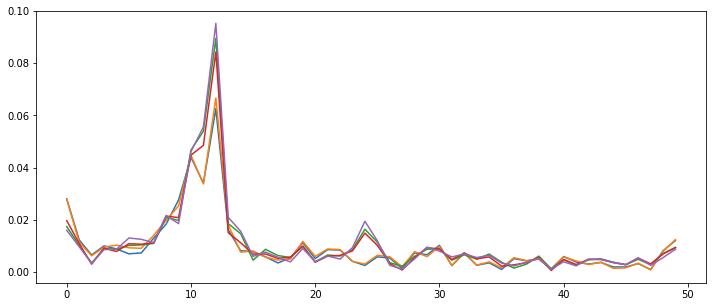

In [26]:
# GenSig_zVar
N_Gen= 300
SigGen5, Amplitude5 = GenSig_zVar(FeatGenModel, ReconModel, 0.05, N_Gen=N_Gen)
SigGen4, Amplitude4 = GenSig_zVar(FeatGenModel, ReconModel,  0.04, N_Gen=N_Gen)
SigGen3, Amplitude3 = GenSig_zVar(FeatGenModel, ReconModel,  0.03, N_Gen=N_Gen)
SigGen2, Amplitude2 = GenSig_zVar(FeatGenModel, ReconModel,  0.02, N_Gen=N_Gen)
SigGen1, Amplitude1 = GenSig_zVar(FeatGenModel, ReconModel,  0.01, N_Gen=N_Gen)

plt.figure(figsize=(12, 5))
idx = 20
plt.plot(Amplitude5[idx, 1:51])
plt.plot(Amplitude4[idx, 1:51])
plt.plot(Amplitude3[idx, 1:51])
plt.plot(Amplitude2[idx, 1:51])
plt.plot(Amplitude1[idx, 1:51])

In [62]:
JointEntropy 

<KerasTensor: shape=(None,) dtype=float32 (created by layer 'tf.math.reduce_logsumexp_13')>

In [60]:
MarginalEntropies

<KerasTensor: shape=(None,) dtype=float32 (created by layer 'tf.math.reduce_sum_104')>

In [19]:
BatSize = 3000


### KL Divergence for p(FCs) vs q(FCs)
BernP = 0.5 # hyperparameter
FCs = SigBandRepModel.get_layer('FC_Mu').output 
kl_Loss_FC = FCs*(tf.math.log(FCs) - tf.math.log(BernP)) + (1-FCs)*(tf.math.log(1-FCs) - tf.math.log(1-BernP))
kl_Loss_FC = tf.reduce_mean(kl_Loss_FC )
kl_Loss_FC = Beta_Fc * tf.abs(kl_Loss_FC - Capacity_Fc)


### Total Correlation # KL(q(z)||prod_j q(z_j)) = log q(z) - sum_j log q(z_j)
'Reference: https://github.com/YannDubs/disentangling-vae/issues/60#issuecomment-705164833' 
'https://github.com/JunetaeKim/disentangling-vae-torch/blob/master/disvae/utils/math.py#L54'
'https://github.com/rtqichen/beta-tcvae/blob/master/elbo_decomposition.py'
Z_Mu, Z_Log_Sigma, Zs = SigBandRepModel.get_layer('Z_Mu').output, SigBandRepModel.get_layer('Z_Log_Sigma').output, SigBandRepModel.get_layer('Zs').output
LogProb_QZi = LogNormalDensity(Zs[:, None], Z_Mu[None], Z_Log_Sigma[None])
LogProb_QZ = -tf.math.log(BatSize*1.) + tf.reduce_sum(LogProb_QZi, axis=2, keepdims=False)
JointEntropy  = tf.reduce_logsumexp(LogProb_QZ,   axis=1,   keepdims=False)
MarginalEntropies = tf.reduce_sum( - tf.math.log(BatSize*1.) + tf.reduce_logsumexp(LogProb_QZi, axis=1),  axis=1)
kl_Loss_TC = tf.reduce_mean( JointEntropy - MarginalEntropies)
kl_Loss_TC = Beta_TC * kl_Loss_TC


### MI Loss ; I[z;x] = KL[q(z,x)||q(x)q(z)] = E_x[KL[q(z|x)||q(z)]]
Log_QZX = tf.reduce_sum(LogNormalDensity(Zs, Z_Mu, Z_Log_Sigma), axis=1)
kl_Loss_MI = tf.reduce_mean(Log_QZX - JointEntropy)
kl_Loss_MI = Beta_MI * kl_Loss_MI


### KL Divergence for p(Z) vs q(Z) # dw_kl_loss is KL[q(z)||p(z)] instead of usual KL[q(z|x)||p(z))]
Log_PZ = tf.reduce_sum(LogNormalDensity(Zs, 0., 0.), axis=1)
DW_kl_Loss_Z = tf.reduce_mean( MarginalEntropies - Log_PZ)
kl_Loss_Z = Beta_Z * tf.abs(DW_kl_Loss_Z - Capacity_Z)


In [72]:
BatSize = 2000
Nsample = 1
LogProb_QZi = tf.random.uniform((BatSize,BatSize, 50)) 
LogProb_QZ = -tf.math.log(Nsample*BatSize*1.) + tf.reduce_sum(LogProb_QZi, axis=2, keepdims=False)
JointEntropy  = tf.reduce_logsumexp(LogProb_QZ,   axis=1,   keepdims=False)
MarginalEntropies = tf.reduce_sum( - tf.math.log(Nsample*BatSize*1.) + tf.reduce_logsumexp(LogProb_QZi, axis=1),  axis=1)
tf.reduce_mean( JointEntropy - MarginalEntropies)

<tf.Tensor: shape=(), dtype=float32, numpy=-0.010186335>

In [46]:
tf.reduce_sum(LogProb_QZi, axis=2, keepdims=False)

<tf.Tensor: shape=(2000, 2000), dtype=float32, numpy=
array([[24.651846, 25.677773, 26.20599 , ..., 26.715303, 25.595608,
        25.839687],
       [30.075563, 25.403683, 23.291748, ..., 23.841898, 30.798717,
        23.832748],
       [25.63814 , 24.95497 , 25.712454, ..., 24.994421, 25.728453,
        25.622215],
       ...,
       [24.047682, 27.327286, 23.909807, ..., 27.622005, 24.707834,
        21.310968],
       [21.874691, 22.95828 , 24.284054, ..., 24.280186, 27.499866,
        22.40513 ],
       [22.791956, 25.639994, 23.692902, ..., 24.20381 , 25.105522,
        21.337473]], dtype=float32)>

In [21]:
MarginalEntropies

<KerasTensor: shape=(None,) dtype=float32 (created by layer 'tf.math.reduce_sum_41')>

In [20]:
Log_QZX 


<KerasTensor: shape=(None,) dtype=float32 (created by layer 'tf.math.reduce_sum_42')>